# Multilayer QG

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import einops
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float

from jaxsw._src.domain.base import Domain
from jaxsw._src.operators.functional import advection as F_adv
from jaxsw._src.operators.functional import geostrophic as F_geos
from jaxsw._src.operators.functional import cgrid as F_cgrid
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.boundaries.helmholtz import enforce_boundaries_helmholtz
from jaxsw._src.models import qg_louis as F_louis
from jaxsw._src.models import qg_ml as F_qgml

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/eman/miniconda3/envs/jaxsw/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [2]:
from loguru import logger


def plot_field(field):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(8, 3))

    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i], cmap="coolwarm")
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = np.min(quantity)
    max_ = np.max(quantity)
    mean_ = np.mean(quantity)
    median_ = np.mean(quantity)
    logger.debug(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In this problem, we are looking at sea surface height (SSH) in relation to the Quasi-Geostrophic (QG) equations. These equations are a simplified form for the Navier-Stokes equations with approximations like *hydrostatic approximation*, *small aspect ratio*, and a *small Rossby number*. Ideally, these equations might be a decent approximation at mesoscale (100km - 10,000km). In this application, we will see how SSH propagates with the QG equations.

## Equations


$$
\partial_t q_k + (u_kq_k)_x + (v_kq_k)_y = F_k + D_k
$$ (eq:qg_form_adv)

The term that links each of the layers together, $\mathbf{A}$, is a tri-diagonal matrix that can be written as

$$
\mathbf{A} =
\begin{bmatrix}
\frac{1}{H_1 g_1'} & \frac{-1}{H_1 g_2'} & \ldots & \ldots & \ldots  \\
\frac{-1}{H_2 g_1'} & \frac{1}{H_1}\left(\frac{1}{g_1'} + \frac{1}{g_2'} \right) & \frac{-1}{H_2 g_2'} & \ldots & \ldots  \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
\ldots & \ldots & \frac{-1}{H_{n-1} g_{n-2}'} & \frac{1}{H_{n-1}}\left(\frac{1}{g_{n-2}'} + \frac{1}{g_{n-1}'} \right) & \frac{-1}{H_{n-1} g_{n-2}'}  \\
\ldots & \ldots& \ldots & \frac{-1}{H_n g_{n-1}'} & \frac{1}{H_n g_{n-1}'}   \\
\end{bmatrix}
$$ (eq:qg_A)

In the paper [[Thiry et al., 2023](https://doi.org/10.22541/essoar.167397445.54992823/v1)], they use the following method

$$
\begin{aligned}
\text{Hyperviscosity}: && 
\boldsymbol{D_1} &= 
-a_4\boldsymbol{\nabla}_H^6\psi\\
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]\\
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

## Parameters

In [3]:
a_4 = 5.0e11  # 2.0e9 #
params = F_qgml.PDEParams(a_4=a_4)

## Domain

In [4]:
# Low Resolution
Nx, Ny = 97, 121
# High Resolution
# Nx, Ny = 769, 961

Lx, Ly = 3840.0e3, 4800.0e3

# initialize domain
domain = Domain.from_numpoints(xmin=(0, 0), xmax=(Lx, Ly), N=(Nx, Ny))

In [5]:
domain.dx, domain.Nx, domain.Lx, domain.cell_volume, domain.ndim

((40000.0, 40000.0), (97, 121), (3840000.0, 4800000.0), 1600000000.0, 2)

In [6]:
# # initialize domain
# # domain = Domain.from_numpoints(xmin=(0, 0), xmax=(Lx, Ly), N=(Nx+1, Ny+1))
# domain = F_qgml.Domain(nx=Nx, ny=Ny, Lx=Lx, Ly=Ly)

# domain.dx

### Heights


$$
\mathbf{A} =
\begin{bmatrix}
\frac{1}{H_1 g_1'} & \frac{-1}{H_1 g_2'} & \ldots & \ldots & \ldots  \\
\frac{-1}{H_2 g_1'} & \frac{1}{H_1}\left(\frac{1}{g_1'} + \frac{1}{g_2'} \right) & \frac{-1}{H_2 g_2'} & \ldots & \ldots  \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
\ldots & \ldots & \frac{-1}{H_{n-1} g_{n-2}'} & \frac{1}{H_{n-1}}\left(\frac{1}{g_{n-2}'} + \frac{1}{g_{n-1}'} \right) & \frac{-1}{H_{n-1} g_{n-2}'}  \\
\ldots & \ldots& \ldots & \frac{-1}{H_n g_{n-1}'} & \frac{1}{H_n g_{n-1}'}   \\
\end{bmatrix}
$$ (eq:qg_A)

In [7]:
from jaxsw._src.domain.qg import LayerDomain

# heights
heights = [350.0, 750.0, 2900.0]

# reduced gravities
reduced_gravities = [0.025, 0.0125]

layer_domain = LayerDomain(heights, reduced_gravities)

In [8]:
layer_domain.A

Array([[ 0.11428571, -0.11428571,  0.        ],
       [-0.05333333,  0.16      , -0.10666667],
       [ 0.        , -0.02758621,  0.02758621]], dtype=float64)

In [9]:
layer_domain.lambd, layer_domain.A_layer_2_mode, layer_domain.A_mode_2_layer

(Array([ 2.28183707e-01,  7.36882145e-02, -4.04361683e-18], dtype=float64),
 Array([[-0.43193138,  0.92242719, -0.49049581],
        [-0.65802762, -0.50089268,  1.15892029],
        [-0.15155445, -0.32475953, -1.25573684]], dtype=float64),
 Array([[-0.70499319, -0.92396019, -0.57735027],
        [ 0.70260146, -0.32821664, -0.57735027],
        [-0.09662189,  0.19639605, -0.57735027]], dtype=float64))

### Helmholtz Matrices

We can precompute the Helmoltz matrices

$$
\text{Helmholtz}:=\left(\alpha\boldsymbol{\nabla}-\beta\right)u
$$

where

$$
\begin{aligned}
\alpha &= \frac{1}{f_0^2} \\
\beta &= \lambda
\end{aligned}
$$

In [10]:
from jaxsw._src.operators.functional import elliptical as F_elliptical

In [11]:
layer_domain.lambd

Array([ 2.28183707e-01,  7.36882145e-02, -4.04361683e-18], dtype=float64)

In [12]:
# create Helmholtz Matrix
helmoltz_dst_mat = F_qgml.create_qgml_helmholtz_matrix(
    domain, layer_domain.lambd, params.f0
)

print_debug_quantity(helmoltz_dst_mat[0], "helmholtz")
print_debug_quantity(helmoltz_dst_mat[1], "helmholtz")
print_debug_quantity(helmoltz_dst_mat[2], "helmholtz")

2023-07-12 18:47:29.460 | DEBUG    | __main__:print_debug_quantity:22 - helmholtz: (95, 119) | -7.969477e-01 | -5.126282e-01 | -5.126282e-01 | -2.283086e-01
2023-07-12 18:47:29.462 | DEBUG    | __main__:print_debug_quantity:22 - helmholtz: (95, 119) | -6.424522e-01 | -3.581327e-01 | -3.581327e-01 | -7.381310e-02
2023-07-12 18:47:29.464 | DEBUG    | __main__:print_debug_quantity:22 - helmholtz: (95, 119) | -5.687640e-01 | -2.844445e-01 | -2.844445e-01 | -1.248847e-04


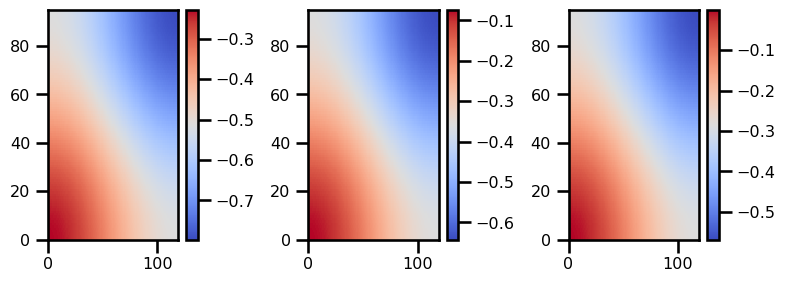

In [13]:
plot_field(helmoltz_dst_mat)

### Inversion

We are interested in solving for the Helmholtz equation which is given by

$$
(\boldsymbol{\alpha\nabla}_H^2 - \boldsymbol{\beta})p = q
$$

In [14]:
helmoltz_dst_mat.shape

(3, 95, 119)

#### Homogeneous Solution

First, we need to use the scheme to solve the homogeneous Helmholtz equation for the baroclinic nodes.
The homoegeneous equation is given by:

$$
(\boldsymbol{\nabla}_H^2 - \boldsymbol{\beta})p = 0
$$

Let's reformulate the pressure to be:

$$
p = \mathbf{L} + \beta s
$$

where $\mathbf{L}$ is a known solution of the Laplace's equation with non-zero boundaries.

$$
\begin{aligned}
\boldsymbol{\nabla}_H^2\mathbf{L} &= 0 && && x\in\Omega\\
\boldsymbol{F}_{BC}(\mathbf{L}) &= b && && x\in\partial\Omega\\
\end{aligned}
$$

 which is non


In [15]:
homogeneous_sol = F_qgml.helmholtz_homogeneous_sol_multilayer(
    helmoltz_dst_mat, layer_domain.lambd, domain
)
print_debug_quantity(homogeneous_sol)

2023-07-12 18:47:30.258 | DEBUG    | __main__:print_debug_quantity:22 - : (2, 97, 121) | -3.576361e-12 | 4.449322e-06 | 4.449322e-06 | 8.520065e-05


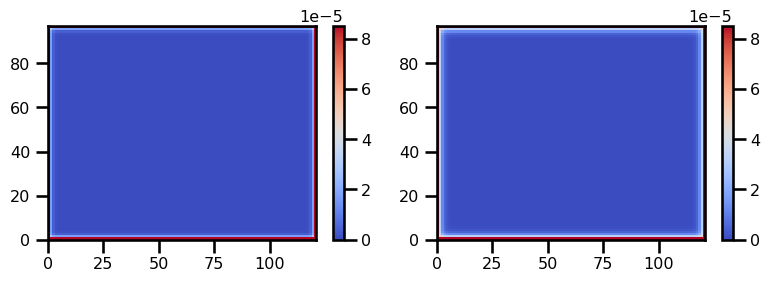

In [16]:
plot_field(homogeneous_sol)

### Alpha Matrix

In [17]:
alpha_matrix = F_qgml.compute_alpha_matrix(layer_domain.A_mode_2_layer, homogeneous_sol)

print_debug_quantity(alpha_matrix)

2023-07-12 18:47:30.618 | DEBUG    | __main__:print_debug_quantity:22 - : (2, 2) | -2.558977e+05 | -1.140663e+05 | -1.140663e+05 | 2.813377e-11


## Forcing

In [18]:
from jaxsw._src.forcing import wind as F_wind

tau = F_wind.init_tau(domain, tau0=2.0e-5)
print_debug_quantity(tau, "Tau")
wind_forcing = F_wind.calculate_wind_forcing(tau, domain) / (params.f0 * heights[0])
print_debug_quantity(wind_forcing, "wind_forcing")

2023-07-12 18:47:30.658 | DEBUG    | __main__:print_debug_quantity:22 - Tau: (2, 97, 121) | -1.999326e-05 | 3.348584e-22 | 3.348584e-22 | 2.000000e-05
2023-07-12 18:47:31.571 | DEBUG    | __main__:print_debug_quantity:22 - wind_forcing: (95, 119) | -7.905821e-10 | 4.311263e-13 | 4.311263e-13 | 7.905821e-10


In [19]:
def calculate_wind_forcing(tau, domain):
    # move from edges to nodes
    tau_x = F_grid.x_average_2D(tau[0])
    tau_y = F_grid.y_average_2D(tau[1])

    # calculate curl
    dF2dX = (tau_y[1:] - tau_y[:-1]) / domain.dx[0]
    dF1dY = (tau_x[:, 1:] - tau_x[:, :-1]) / domain.dx[1]
    curl_stagg = dF2dX - dF1dY

    # move from nodes to faces
    return F_grid.center_average_2D(curl_stagg)


wind_forcing = calculate_wind_forcing(tau, domain)

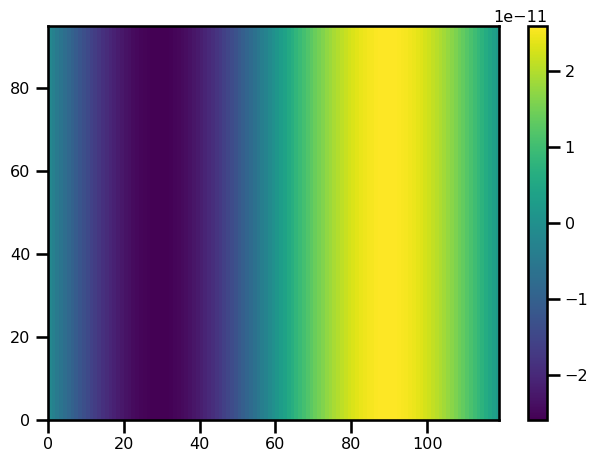

In [20]:
fig, ax = plt.subplots()

pts = ax.pcolormesh(wind_forcing)
plt.colorbar(pts)

plt.tight_layout()
plt.show()

## Pressure

In [21]:
if domain.Nx[0] == 97:
    p = np.load("./p_380yrs_HRDS.npy", allow_pickle=True).astype(np.float64)
else:
    p = jnp.zeros_like(domain.grid[..., 0])
    p = einops.repeat(p, "i j -> 3 i j")
p.shape

(3, 97, 121)

## Vorticity

$$
f_0 q = (\boldsymbol{\nabla}_H^2 - f_0^2A)p + f_0\beta(y-y_0)
$$

In [22]:
import functools as ft

bc_fn = ft.partial(F_qgml.custom_boundaries, constant=params.zfbc)
q = F_qgml.pressure_to_vorticity(jnp.asarray(p), bc_fn, layer_domain.A, params, domain)
print_debug_quantity(p, "PRESSURE")
print_debug_quantity(q, "VORTICITY")

2023-07-12 18:47:33.131 | DEBUG    | __main__:print_debug_quantity:22 - PRESSURE: (3, 97, 121) | -4.332182e+00 | 3.335592e-02 | 3.335592e-02 | 3.561408e+00
2023-07-12 18:47:33.167 | DEBUG    | __main__:print_debug_quantity:22 - VORTICITY: (3, 97, 121) | -4.657202e-01 | -6.053233e-06 | -6.053233e-06 | 4.963626e-01


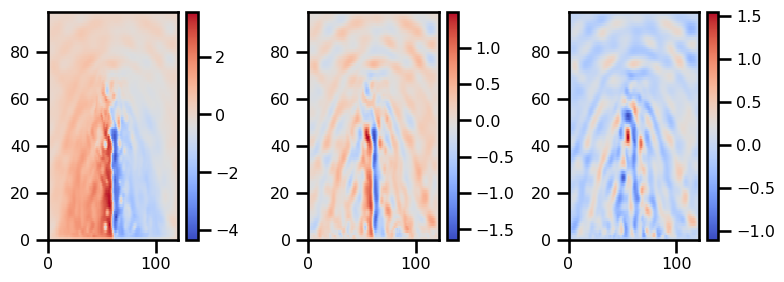

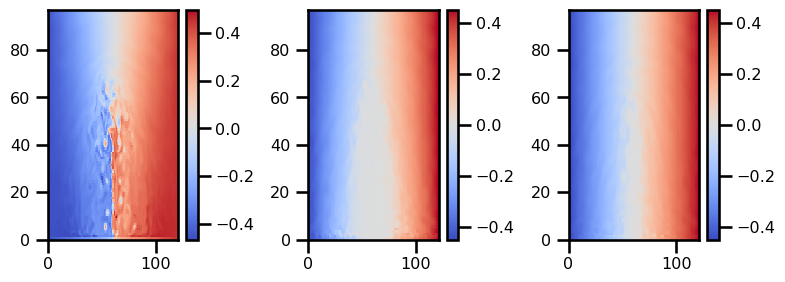

In [23]:
plot_field(p)
plot_field(q)

## RHS

$$
\begin{aligned}
\text{Advection}: && 
\boldsymbol{D_1} &= 
-\frac{1}{f_0}\boldsymbol{J}(q,p)\\
\text{Diffusion}: && 
\boldsymbol{D_2} &= 
\frac{a_2}{f_0}\boldsymbol{\nabla}_H^4\psi\\
\text{HyperDiffusion}: && 
\boldsymbol{D_2} &= 
-\frac{a_4}{f_0}\boldsymbol{\nabla}_H^6\psi\\
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]\\
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

#### Advection Term

$$
\boldsymbol{D_1} = 
-\frac{1}{f_0}\boldsymbol{J}(q,p)
$$

Here, we will use the (determinant) Jacobian to calculate this.

In [24]:
from jaxsw._src.operators.functional.advection import det_jacobian

In [25]:
rhs_advection = (1 / params.f0) * det_jacobian(q, p, domain.dx[0], domain.dx[1])
print_debug_quantity(p, "PRESSURE")
print_debug_quantity(q, "VORTICITY")
print_debug_quantity(rhs_advection, "RHS ADVECTION")

2023-07-12 18:47:33.874 | DEBUG    | __main__:print_debug_quantity:22 - PRESSURE: (3, 97, 121) | -4.332182e+00 | 3.335592e-02 | 3.335592e-02 | 3.561408e+00
2023-07-12 18:47:33.876 | DEBUG    | __main__:print_debug_quantity:22 - VORTICITY: (3, 97, 121) | -4.657202e-01 | -6.053233e-06 | -6.053233e-06 | 4.963626e-01
2023-07-12 18:47:33.919 | DEBUG    | __main__:print_debug_quantity:22 - RHS ADVECTION: (3, 95, 119) | -1.564097e-06 | -2.804566e-12 | -2.804566e-12 | 1.195297e-06


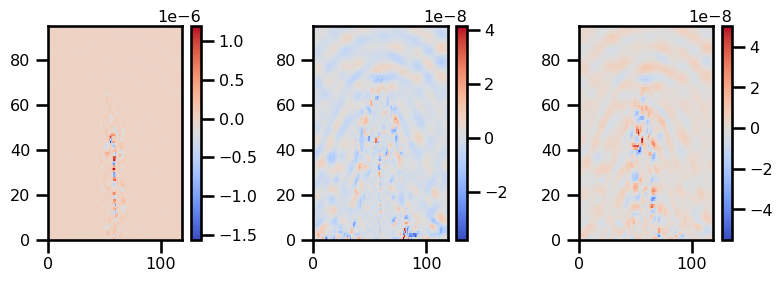

In [26]:
plot_field(rhs_advection)

#### Diffusion Term

$$
\boldsymbol{D_2} = 
\frac{a_2}{f_0}\boldsymbol{\nabla}_H^4\psi
$$

#### HyperDiffusion Term

$$
\boldsymbol{D_2} = 
\frac{a_2}{f_0}\boldsymbol{\nabla}_H^4\psi
$$

**Wind Stress**

$$
\boldsymbol{F} = 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]^\top
$$

**Bottom Friction Term**

$$
\boldsymbol{D_2} = 
\frac{a_2}{f_0}\boldsymbol{\nabla}_H^4\psi
$$

In [27]:
print_debug_quantity(p, "PRESSURE")
rhs = F_qgml.rhs_pde(
    q, jnp.asarray(p), bc_fn, params, layer_domain, domain, wind_forcing
)
print_debug_quantity(rhs, "RHS")

2023-07-12 18:47:34.327 | DEBUG    | __main__:print_debug_quantity:22 - PRESSURE: (3, 97, 121) | -4.332182e+00 | 3.335592e-02 | 3.335592e-02 | 3.561408e+00
2023-07-12 18:47:34.706 | DEBUG    | __main__:print_debug_quantity:22 - RHS: (3, 95, 119) | -1.502200e-06 | -7.205300e-12 | -7.205300e-12 | 1.339382e-06


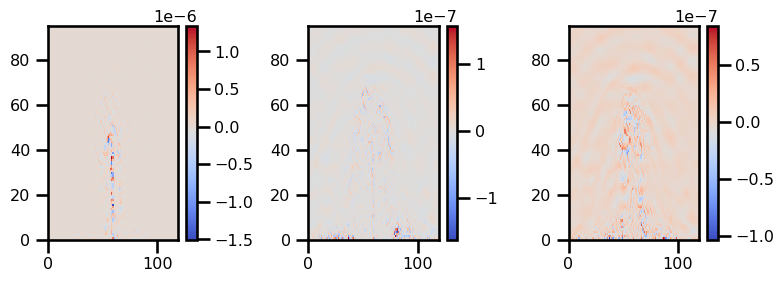

In [28]:
plot_field(rhs)

## Time Step

In [29]:
import typing as tp


class QGState(tp.NamedTuple):
    q: Array
    p: Array


class QGARGS(tp.NamedTuple):
    params: tp.NamedTuple
    domain: Domain
    layer_domain: LayerDomain
    wind_forcing: Array
    helmoltz_dst_mat: Array
    alpha_matrix: Array
    homogeneous_sol: Array
    bc_fn: tp.Callable

In [30]:
if domain.Nx[0] == 97:
    p = jnp.asarray(
        np.load("./p_380yrs_HRDS.npy", allow_pickle=True).astype(np.float64)
    )
else:
    p = jnp.zeros_like(domain.grid[..., 0])
    p = einops.repeat(p, "i j -> 3 i j")

import functools as ft

bc_fn = ft.partial(F_qgml.custom_boundaries, constant=params.zfbc)
q = F_qgml.pressure_to_vorticity(jnp.asarray(p), bc_fn, layer_domain.A, params, domain)

state_init = F_qgml.QGState(p=p, q=q)

args = F_qgml.QGARGS(
    domain=domain,
    layer_domain=layer_domain,
    wind_forcing=wind_forcing,
    helmoltz_dst_mat=helmoltz_dst_mat,
    alpha_matrix=alpha_matrix,
    homogeneous_sol=homogeneous_sol,
    bc_fn=bc_fn,
)

In [31]:
import typing as tp


def pde_time_step(t, state, args):
    # unpack state
    p, q = state.p, state.q

    # RHS of PDE for Q (INTERIOR)
    dq_f0 = F_qgml.rhs_pde(
        q,
        p,
        bc_fn=bc_fn,
        params=args.params,
        layer_domain=args.layer_domain,
        domain=args.domain,
        wind_forcing=args.wind_forcing,
    )
    print_debug_quantity(dq_f0, "dq_f0")
    # pad for original domain
    dq_f0 = jnp.pad(dq_f0, ((0, 0), (1, 1), (1, 1)))

    # PRESSURE (INTERIOR)
    rhs_helmholtz = jnp.einsum("ij,jkl->ikl", args.layer_domain.A_layer_2_mode, dq_f0)
    print_debug_quantity(rhs_helmholtz, "rhs_helmholtz")
    dp_modes = jax.vmap(F_elliptical.inverse_elliptic_dst, in_axes=(0, 0))(
        rhs_helmholtz[:, 1:-1, 1:-1], args.helmoltz_dst_mat
    )

    dp_modes = jnp.pad(dp_modes, ((0, 0), (1, 1), (1, 1)))
    print_debug_quantity(dp_modes, "dp_modes")

    # ensure mass conservation
    print_debug_quantity(args.alpha_matrix, "alpha_matrix")
    dalpha = args.alpha_matrix @ dp_modes[..., :-1, :, :].mean((-2, -1))
    dalpha = einops.repeat(dalpha, "i -> i 1 1")
    print_debug_quantity(dalpha, "dalpha")
    print_debug_quantity(args.homogeneous_sol, "homogeneous_sol")
    dp_modes = dp_modes.at[..., :-1, :, :].set(
        dp_modes[..., :-1, :, :] + dalpha * args.homogeneous_sol
    )
    print_debug_quantity(dp_modes, "dp_modes")
    dp = jnp.einsum("ij,jkl->ikl", args.layer_domain.A_mode_2_layer, dp_modes)
    print_debug_quantity(dp, "dp")

    delta_p_boundaries = args.bc_fn(dp / (params.f0 * args.domain.dx[0]) ** 2)
    print_debug_quantity(delta_p_boundaries, "delta_p_boundaries")

    # apply boundaries
    print(delta_p_boundaries.shape, args.layer_domain.A.shape, dp.shape)
    dq_f0_boundaries = delta_p_boundaries - jnp.einsum(
        "ij,jkl->ikl", args.layer_domain.A, dp
    )

    dq_f0 = F_qgml.apply_boundaries(dq_f0, dq_f0_boundaries)

    return dp, q


out_state = F_qgml.pde_time_step(p, q, params, args)
print_debug_quantity(out_state[0], "dp")
print_debug_quantity(out_state[1], "dq_f0")

2023-07-12 18:47:35.234 | DEBUG    | __main__:print_debug_quantity:22 - dp: (3, 97, 121) | -5.185125e-06 | 2.919435e-08 | 2.919435e-08 | 5.175048e-06
2023-07-12 18:47:35.235 | DEBUG    | __main__:print_debug_quantity:22 - dq_f0: (3, 97, 121) | -1.502200e-06 | -8.966964e-12 | -8.966964e-12 | 1.339382e-06


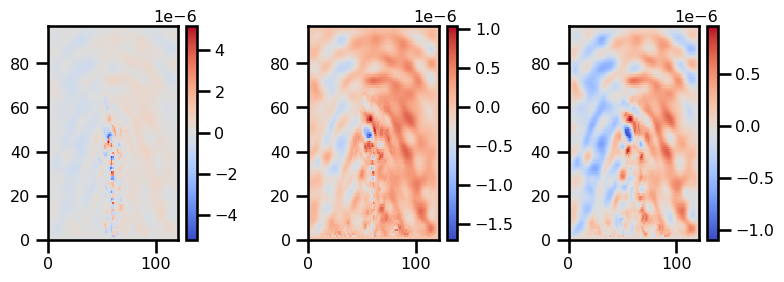

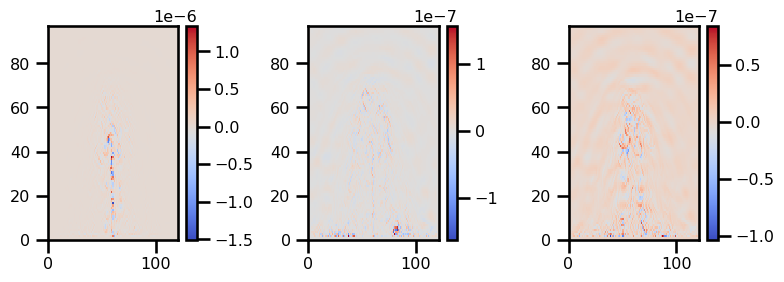

In [32]:
plot_field(out_state[0])
plot_field(out_state[1])

In [58]:
pde_args = QGARGS(
    params=params,
    domain=domain,
    layer_domain=layer_domain,
    wind_forcing=wind_forcing,
    helmoltz_dst_mat=helmoltz_dst_mat,
    alpha_matrix=alpha_matrix,
    homogeneous_sol=homogeneous_sol,
    bc_fn=bc_fn,
)

pde_time_step_fn = ft.partial(F_qgml.pde_time_step, params=params, args=pde_args)

rhs_time_step_jitted = jax.jit(pde_time_step_fn)


# vector field
def vector_field(t, state, args):
    p, q = state
    p, q = rhs_time_step_jitted(p, q)

    return (p, q)


if domain.Nx[0] == 97:
    p = np.load("./p_380yrs_HRDS.npy", allow_pickle=True).astype(np.float64)
else:
    p = jnp.zeros_like(domain.grid[..., 0])
    p = einops.repeat(p, "i j -> 3 i j")


bc_fn = ft.partial(F_qgml.custom_boundaries, constant=params.zfbc)
q = F_qgml.pressure_to_vorticity(jnp.asarray(p), bc_fn, layer_domain.A, params, domain)

In [59]:
dp, dq = vector_field(0, (p, q), None)
print_debug_quantity(dp, "dp")
print_debug_quantity(dq, "dq_f0")

2023-07-12 18:57:12.848 | DEBUG    | __main__:print_debug_quantity:22 - dp: (3, 97, 121) | -5.185125e-06 | 2.919435e-08 | 2.919435e-08 | 5.175048e-06
2023-07-12 18:57:12.848 | DEBUG    | __main__:print_debug_quantity:22 - dq_f0: (3, 97, 121) | -1.502200e-06 | -8.966964e-12 | -8.966964e-12 | 1.339382e-06


## Time Stepping

We're going to use the Heun method.
I'll also be using `diffrax` to handle the time stepping :)

In [60]:
dt = 1_200  # LR #600 # HR #
n_years = 2
n_days = 365
tmin = 0
tmax = pd.to_timedelta(n_years * n_days, unit="day").total_seconds()
ts = jnp.arange(tmin, tmax, dt)

In [61]:
len(ts)

52560

In [62]:
if domain.Nx[0] == 97:
    p = np.load("./p_380yrs_HRDS.npy", allow_pickle=True).astype(np.float64)
else:
    p = jnp.zeros_like(domain.grid[..., 0])
    p = einops.repeat(p, "i j -> 3 i j")


bc_fn = ft.partial(F_qgml.custom_boundaries, constant=params.zfbc)
q = F_qgml.pressure_to_vorticity(jnp.asarray(p), bc_fn, layer_domain.A, params, domain)

state = (p, q)


solver = dfx.Heun()
solver_state = solver.init(
    terms=dfx.ODETerm(vector_field),
    t0=tmax,
    t1=tmin + dt,
    y0=state,
    args=None,
)

In [63]:
n_check = 2_000
freq_log = 1_000  # LR #50 # HR #
n_check

2000

In [64]:
saved_states = dict(q=list(), p=list(), t=list())

solver_step = jax.jit(solver.step, static_argnames=("made_jump", "terms"))

with tqdm(ts) as pbar:
    for t in pbar:
        state, _, _, solver_state, _ = solver_step(
            terms=dfx.ODETerm(vector_field),
            t0=t,
            t1=t + dt,
            y0=state,
            args=None,
            solver_state=solver_state,
            made_jump=False,
        )

        msg1 = f"PRESSURE: {jnp.min(state[0]):.4e} | {jnp.max(state[0]):.4e}"
        msg2 = f"VORTICITY: {jnp.min(state[1]):.4e} | {jnp.max(state[1]):.4e}"
        pbar.set_description(msg1 + " - " + msg2)

        if t % (freq_log * dt) == 0:
            saved_states["q"].append(state[1])
            saved_states["p"].append(state[0])
            saved_states["t"].append(t)

  0%|          | 0/52560 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Analysis

In [40]:
import xarray as xr


ds_results = xr.Dataset(
    data_vars={
        "q": (("time", "layer", "x", "y"), np.stack(saved_states["q"], axis=0)),
        "p": (("time", "layer", "x", "y"), np.stack(saved_states["p"], axis=0)),
    },
    coords={
        "time": (("time"), np.stack(saved_states["t"], axis=0)),
        "layer": (("layer"), np.arange(3)),
        "x": (("x"), np.arange(0, domain.Lx[0] + 1, domain.dx[0])),
        "y": (("y"), np.arange(0, domain.Lx[1] + 1, domain.dx[1])),
    },
)
ds_results

<xarray.Dataset>
Dimensions:  (time: 53, layer: 3, x: 97, y: 121)
Coordinates:
  * time     (time) float64 0.0 1.2e+06 2.4e+06 ... 6e+07 6.12e+07 6.24e+07
  * layer    (layer) int64 0 1 2
  * x        (x) float64 0.0 4e+04 8e+04 1.2e+05 ... 3.76e+06 3.8e+06 3.84e+06
  * y        (y) float64 0.0 4e+04 8e+04 1.2e+05 ... 4.72e+06 4.76e+06 4.8e+06
Data variables:
    q        (time, layer, x, y) float64 -0.4522 -0.4529 ... 0.4412 0.449
    p        (time, layer, x, y) float64 0.009725 0.02492 ... 0.007248 0.003341

In [41]:
from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_p_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.p.min())
    vmax = kwargs.pop("vmax", sub.p.max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(15, 10)

    ax = fig.subplots(ncols=3, nrows=2)

    for i in range(3):
        # NATL60
        pts = sub.p.isel(layer=i).plot.pcolormesh(
            ax=ax[0, i],
            cmap="viridis",
            add_colorbar=True,
            vmin=vmin,
            vmax=vmax,
            # **kwargs
        )

        loc = ticker.MaxNLocator(6)
        levels = loc.tick_values(vmin, vmax)
        sub.p.isel(layer=i).plot.contour(
            ax=ax[0, i],
            levels=levels,
            vmin=vmin,
            vmax=vmax,
            alpha=0.5,
            linewidths=1,
            cmap="black",
            linestyles=np.where(levels >= 0, "-", "--"),
        )

        # ax.set_aspect('equal')
        pts = ax[0, i].set(xlabel="x [m]", ylabel="y [m]", title=f"Layer {i}")

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.q.min())
    vmax = kwargs.pop("vmax", sub.q.max())
    cmap = kwargs.pop("cmap", "viridis")

    for i in range(3):
        # NATL60
        pts = sub.q.isel(layer=i).plot.pcolormesh(
            ax=ax[1, i],
            cmap="RdBu_r",
            add_colorbar=True,
            vmin=vmin,
            vmax=vmax,
            # **kwargs
        )

        loc = ticker.MaxNLocator(6)
        levels = loc.tick_values(vmin, vmax)
        sub.q.isel(layer=i).plot.contour(
            ax=ax[1, i],
            levels=levels,
            vmin=vmin,
            vmax=vmax,
            alpha=0.5,
            linewidths=1,
            cmap="black",
            linestyles=np.where(levels >= 0, "-", "--"),
        )

        # ax.set_aspect('equal')
        pts = ax[0, i].set(xlabel="x [m]", ylabel="y [m]", title=f"Layer {i}")
        plt.tight_layout()
    return None, None


from pathlib import Path


def create_movie(
    var,
    name,
    plotfunc=custom_plot_p_layers,
    framedim: str = "steps",
    file_path=None,
    **kwargs,
):
    if file_path is not None:
        file_name = Path(file_path).joinpath(f"movie_{name}.gif")
    else:
        file_name = Path(f"./movie_{name}.gif")

    mov = Movie(
        var, plotfunc=plotfunc, framedim=framedim, **kwargs, dpi=200, input_check=False
    )
    mov.save(
        file_name,
        remove_movie=False,
        progress=True,
        framerate=3,
        gif_framerate=3,
        overwrite_existing=True,
        gif_resolution_factor=0.5,
        parallel=False,
    )

    return None

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


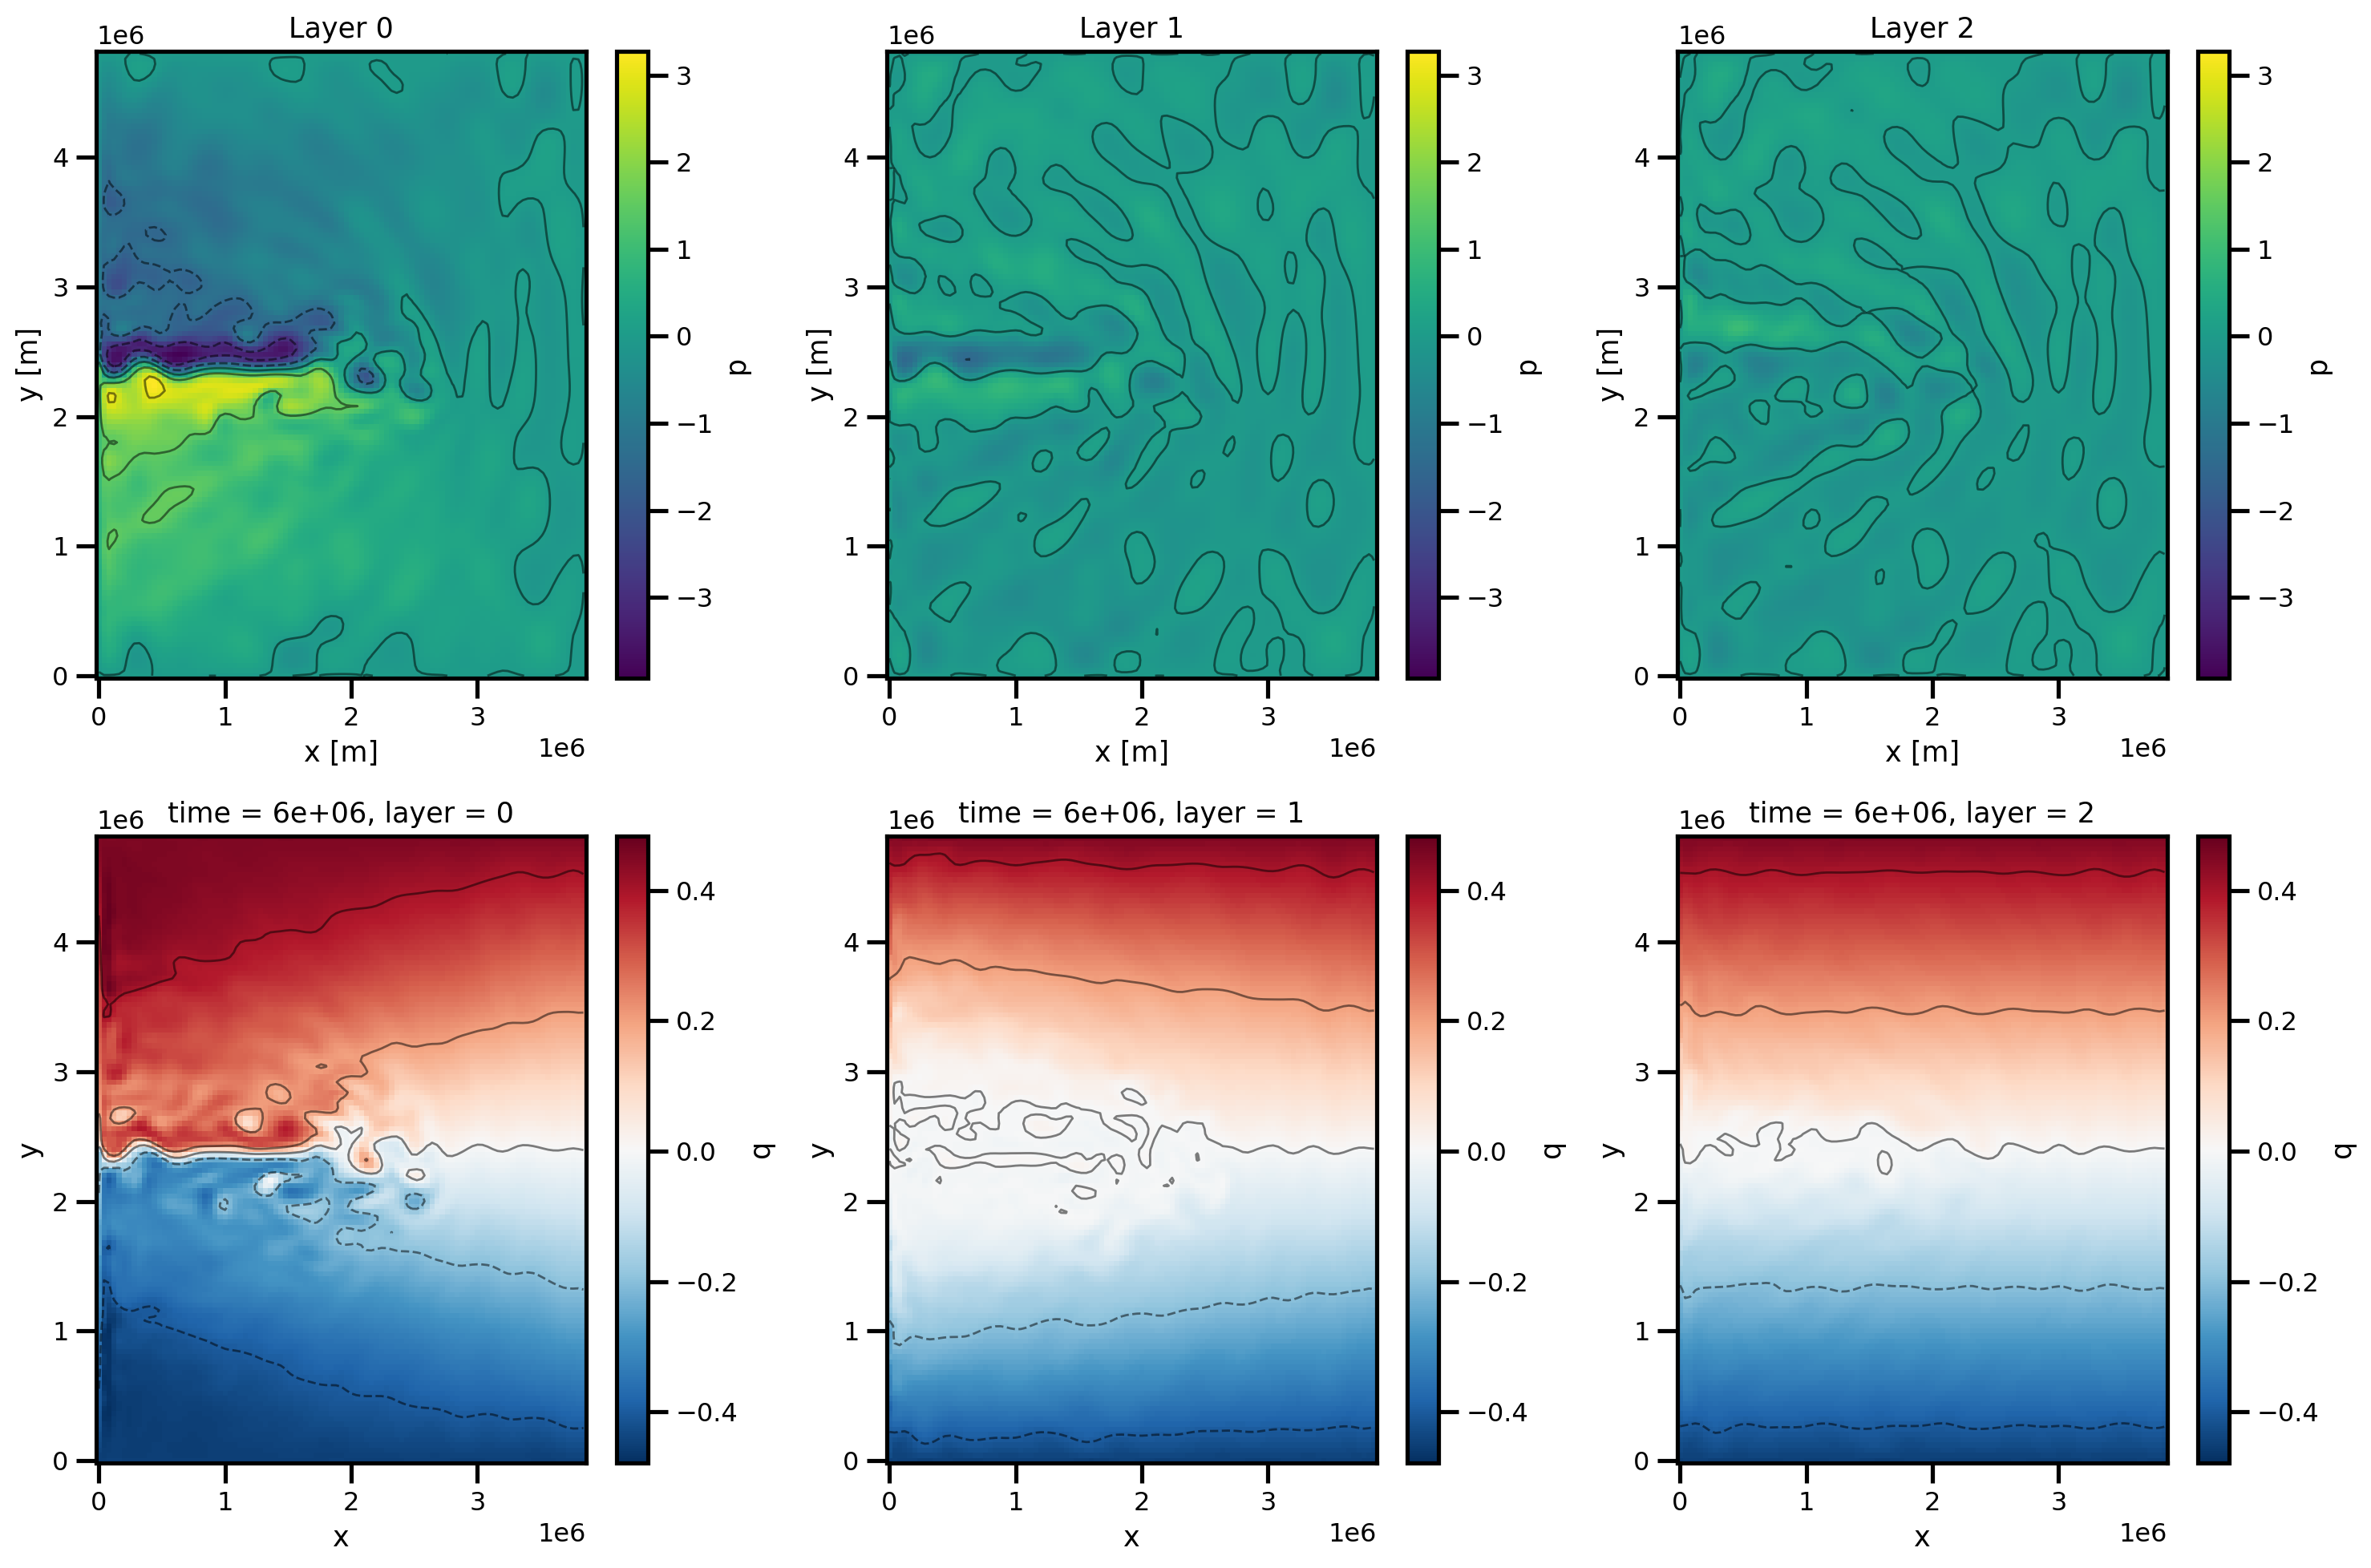

In [42]:
%matplotlib inline
mov = Movie(
    ds_results.transpose("time", "layer", "y", "x"),
    plotfunc=custom_plot_p_layers,
    framedim="time",
    input_check=False,
)
mov.preview(5)

In [43]:
create_movie(
    ds_results.transpose(
        "time", "layer", "y", "x"
    ),  # .sel(time=slice("2017-02-01", "2017-03-01")),
    name="pressure_vorticity_v2",
    plotfunc=custom_plot_p_layers,
    file_path="./",
    framedim="time",
    cmap="viridis",
    robust=True,
)

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


  0%|          | 0/53 [00:00<?, ?it/s]

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303/2500604652.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_71303

Movie created at movie_pressure_vorticity_v2.mp4
GIF created at movie_pressure_vorticity_v2.gif
